# Задание

Сравнить Stacking классификатор, основанный на обычных (простых) и Boosting моделях.
* Выровнять размеры классов, чтобы в каждом было не более 20 000 сообщений.
* Построить два классификатора типа Stacking так, чтобы в одном на первом уровне использовались только Boosting классификаторы, а во втором классификаторе были не Boosting модели.

# Настройки/Импорты

In [1]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm import tqdm # для отслеживания прогресса

import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
from matplotlib.colors import LinearSegmentedColormap # для создания своего cmap

import re # для регулярных выражений
import nltk # для работы с текстом
from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строки

from sklearn.feature_extraction.text import TfidfVectorizer # векторизатор текста
from sklearn.utils import resample # для upsample и downsample данных (выравнивание классов)
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку
from sklearn.model_selection import GridSearchCV # для перебора параметров
from sklearn.model_selection import ShuffleSplit # для кросс-валидации
# ShuffleSplit - Кросс-валидатор случайной перестановки
# Дает индексы для разбиения данных на обучающий и тестовый наборы.
# Примечание: в отличие от других стратегий кросс-валидации, случайное разбиение не гарантирует,
# что все складки будут разными, хотя для больших наборов данных это вполне вероятно.

from sklearn.ensemble import StackingClassifier # Stacking ensemble
from sklearn.neighbors import KNeighborsClassifier # KNN классификатор
from sklearn.tree import DecisionTreeClassifier # Decision Tree классификатор
from sklearn.naive_bayes import MultinomialNB # Байесовский классификатор
from sklearn.linear_model import LogisticRegression # Логистическая регрессия
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier # Boosting классификаторы

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний
import time # для отслеживания времени выполнения

import pickle # для сохранения и загрузки объектов

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [2]:
DATA_DIR = "./data/" # путь до папки с данными
MODELS_DIR = "./models/" # путь до папки с моделями
RANDOM_STATE = 42 # число для задания случайности
CLEANING_VARS = ["none", "stop_words"] # варианты очистки текста
ADD_STOP_WORDS = ["im", "wa", "feel", "feeling"] # дополнительные стоп-слова

TARGET_DTYPE = np.int8 # тип таргета (числовой или str)
DTYPE = np.float32 # используемый тип (по стандарту float64)

SAMPLES_PER_CLASS = 20000 # число сэмплов для каждого класса (если их больше — они обрежутся, если меньше — сгенерируются с помощью sklearn.resample, если None — выравнивание по самому представленному классу)
MIN_DF = 20 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов меньше заданной пропорции (int — абсолютное значение)
MAX_DF = 0.5 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов больше заданной пропорции (int — абсолютное значение)
MAX_FEATURES = 1000 # максимальное число фич (токенов) в словаре векторизатора (чем больше, тем дольше идёт обучение, но и качество лучше)

N_JOBS = -1 # количество потоков для параллельного выполнения некоторых участков кода (связанных с перебором параметров)
VERBOSE = 0 # на сколько подробным должен быть вывод при обучении

TEST_SIZE = 0.2 # размер тестовой выборки
CV_SPLITS = 2 # число разбиений для кросс-валидации

In [4]:
# from google.colab import drive # для Google Drive
# drive.mount('/content/drive') # подключаемся к Google Drive

# # перезаписываем важные переменные
# DATA_DIR = "/content/drive/MyDrive/tmp/data/" # путь до папки с данными
# MODELS_DIR = "/content/drive/MyDrive/tmp/models/" # путь до папки с моделями

Mounted at /content/drive


In [ ]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных потоков

Количество доступных потоков:  4


# Предобработка датасета

In [ ]:
dataset = pd.read_json(DATA_DIR + "data.jsonl", lines=True) # считывание json данных (lines=True если файл записан в виде с разделением данных с помощью строк)
dataset

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


## Первичный анализ

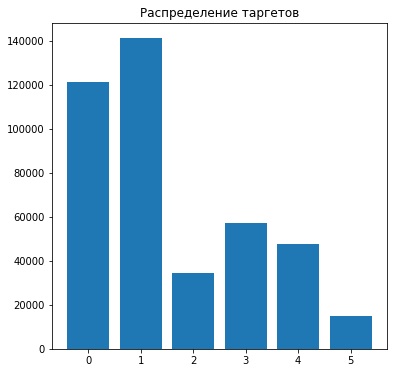

In [ ]:
plt.figure(figsize=(6,6)) # задание размера графика
plt.bar(dataset["label"].value_counts().index, dataset["label"].value_counts()) # построение столбатой диаграммы по данным (dataset["label"].value_counts().index — колонки, dataset["label"].value_counts() — их значения)
plt.title("Распределение таргетов") # название графика
plt.show() # вывод графика

In [ ]:
for col in dataset.columns: # идём по столбцам датасета
    print(f"Столбец '{col}' содержит {dataset[col].isnull().sum()} незаполненных позиций.") # выводим сумму незаполненных значений по рассматриваемому столбцу

Столбец 'text' содержит 0 незаполненных позиций.
Столбец 'label' содержит 0 незаполненных позиций.


In [ ]:
# dataset = dataset[dataset["text"].notnull()] # оставляем те строки, у которых столбец "text" имеет значение
# dataset = dataset[dataset["label"].notnull()] # оставляем те строки, у которых столбец "label" имеет значение

* В данных нет выбросов и пропусков.

## Очистка

На самом деле данный датасет изначально довольно неплохо представлен, он уже в нижнем регистре, в нём нет знаков припинания, чисел или явно мусорных символов... Однако, из него всё ещё можно убрать излишнюю информацию, такую как стоп-слова.

In [ ]:
stop_words = stopwords.words('english') # список стоп-слов для английского языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
stop_words[:10] # первые 10 стоп-слов для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, var, columns=["text"], stop_words=[]) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета (лишние пробелы можно не удалять, так как word_tokenize их сам уберёт).\n
    Parameters:
        * df: рассматриваемый датасет
        * var: тип очистки
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    import re
    # import pymorphy3
    from nltk.tokenize import word_tokenize


    # morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов
    lemmatizer = WordNetLemmatizer() # объект для лемматизации слов


    for column in columns: # идём по переданным столбцам для обработки
        df[column] = df[column].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

        if var in ["trash", "all"]:
            # df[column] = df[column].parallel_apply(lambda text: re.sub('\[\[\w*d*\|', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])
            # df[column] = df[column].parallel_apply(lambda text: re.sub(']', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])

            # df[column] = df[column].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование (например @Soloviev)

            df[column] = df[column].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы

            df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text)) # убираем ссылки (например https://t.co/KN1g4AWFIb)


        if var in ["punctuation", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(<>\[\]%$&]", '', text)) # удаляем различную пунктуацию
            df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


        if var in ["digits", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('\d', '', text)) # удаляем цифры


        df[column] = df[column].parallel_apply(lambda text: word_tokenize(text)) # разбиваем текст на токены
        # df[column] = df[column].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
        df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text]) # лемматизируем слова

        if var in ["stop_words", "all"]:
            df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

        df[column] = df[column].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
        df[column] = df[column].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

        # df = df[df[column].notnull()] # оставляем те строки, у которых рассматриваемый столбец имеет значение
        df = df[df[column] != ""] # оставляем те строки, данные в которых не занулились

    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)
    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset_cleared = clear_data(dataset.copy(), var, ["text"], stop_words) # проводим очистку датасета
    dataset_cleared.to_csv(DATA_DIR + f"data_{var}.csv", sep=";", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:08<01:08, 68.71s/it]

100%|██████████| 2/2 [02:24<00:00, 72.46s/it]


## Отображение самых частых слов в датасете

Данный шаг помогает определить дополнительные, неявные стоп-слова.

In [ ]:
dataset_cleared = pd.read_csv(DATA_DIR + "data_stop_words.csv",  sep=';', encoding='utf8', index_col=False) # считывание данных
dataset_cleared

,text,label
0,awful job get position succeed happen,0
1,alone awful,0
2,ive probably mentioned really proud actually k...,1
3,little low day back,0
4,beleive much sensitive people tend compassionate,2
...,...,...
416788,felt finally accepted bulgarian conservatorie ...,1
416789,take every day come focussing eating better mo...,4
416790,suddenly everything fake,0
416791,eager ever claw back went pear shaped last wee...,1


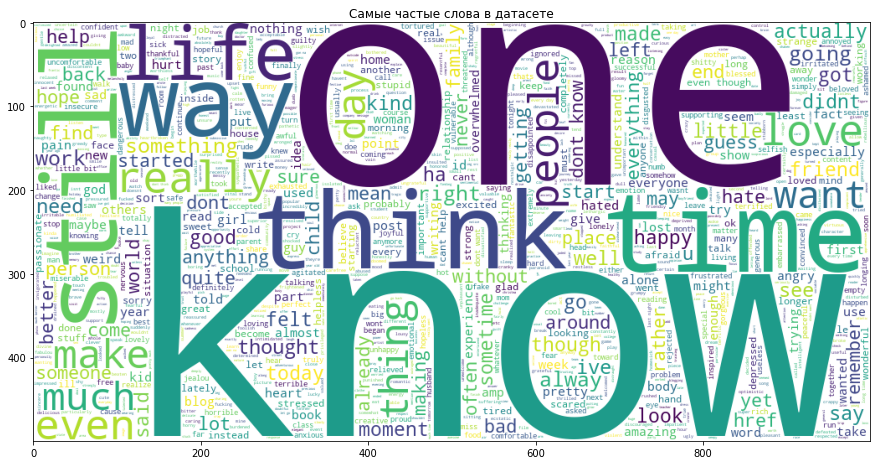

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset_cleared["text"])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера графика
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете") # название графика
plt.show() # вывод графика

* При удалении стоп-слов из датасета 16 строк было выброшено.

# Обучение моделей

## Подготовка

### Используемые объекты

In [3]:
data = {} # словарь под все варианты обработки вида
# {"var 1":
#   {
#     "X_train": [...],
#     "X_test": [...],
#     "y_train": [...],
#     "y_test": [...],
#     "vectorizer": векторизатор
#   }, ...
# }

In [4]:
results = {} # словарь под полученные результаты классификаторов
# {"classifier 1":
#   {
#     "var 1": метрика,
#     "var 2": метрика,
#     ...
#   }, ...
# }

In [5]:
custom_cv = ShuffleSplit(n_splits=CV_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE) # кастомный кросс-валидатор ()
# n_splits — число разбиений для кросс-валидации
# test_size — размер тестовой выборки

In [6]:
cmap = LinearSegmentedColormap.from_list("from_red_to_green", [(1, 0.15, 0.15), (0, 0.6, 0)], N=100) # собственная цветовая палитра (числа в формате RGB от 0 до 1 то есть 255/255)

### Векторизация данных (+resampling)

In [7]:
for var in CLEANING_VARS: # идём по вариантам обработки
    dataset_cleared = pd.read_csv(f"{DATA_DIR}data_{var}.csv",  sep=";", encoding="utf8", index_col=False) # считывание данных об очищенном датасете

    vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=MIN_DF, max_df=MAX_DF, max_features=MAX_FEATURES, dtype=DTYPE) # векторизатор (с ограничениями на построение vocabulary, чтобы вектора были не слишком большие)
    data_X = vectorizer.fit_transform(dataset_cleared["text"]).toarray() # конвертируем документы (текста) в вектора
    print(f"Размерность при варианте обработки '{var}' до: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}.")

    # factorizer = pd.factorize(dataset_cleared["label"]) # перевод строковых таргетов (type: object) в числовой формат (type: int, от 1...)
    # data_y = factorizer[0] # таргеты (уже в числовом формате, под индексом 1 — их названия)
    data_y = dataset_cleared["label"].to_numpy() # берём таргеты (не переводя их в числовой формат)

    if SAMPLES_PER_CLASS: # если число сэплов за класс задано
        max_samples = SAMPLES_PER_CLASS # используем его как параметр для resample
    else: # иначе — выравниваем по самому представленному классу
        max_samples = dataset_cleared["label"].value_counts()[0] # число элементов в наиболее представленном классе
    max_label = dataset_cleared["label"].value_counts().index[0] # название наиболее представленного класса

    # сначала получаем данные о распределении фич для каждого класса, чтобы потом провести их выравнивание (upsampling)
    data_resampled = pd.DataFrame(columns=[*range(data_X.shape[1]), "label"]) # заготовка под DataFrame без дисбаланса классов (слолбцы: data_X.shape[1] фич и "label")
    for label_value in dataset_cleared["label"].unique(): # идём по уникальным таргетам
        data_distribution = data_X[data_y == label_value] # записываем в data_distribution TF-IDF вектора, соответствующие рассматриваемому label_value
        print(f"    В классе '{label_value}' было {len(data_distribution)} записей.")

        data_distribution = resample(data_distribution, n_samples=max_samples, random_state=RANDOM_STATE) # добавляем (удаляем) записи к рассматриваемому таргету до n_samples по соответствующему распределению
        print(f"    В классе '{label_value}' стало {len(data_distribution)} записей.")

        data_for_label = pd.DataFrame(data_distribution) # создаём DataFrame из векторов, соответствующих рассматриваемому таргету
        data_for_label["label"] = label_value # добавляем колонку таргета в DataFrame (у всех строк будет значение рассматриваемого таргета)

        data_resampled = pd.concat([data_resampled, data_for_label]) # соединяем вместе все DataFrame_ы классов

    data_y = data_resampled["label"].values.astype(TARGET_DTYPE) # запоминаем таргеты (array) с приведением к типу DTYPE
    del data_resampled["label"] # в data_resampled (DataFrame) оставляем только вектора фич
    data_X = data_resampled.values # возвращаем фичи к типу array (хоть можно было оставить и DataFrame)

    print(f"Размерность при варианте обработки '{var}' после: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}.")
    print(f"===========================================================================")

    data[var] = {} # заготовка под сплит
    data[var]["X_train"], data[var]["X_test"], data[var]["y_train"], data[var]["y_test"] = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y, shuffle=True)
    # разбиваем датасет (data_X — данные, data_y — таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках и данные должны быть перемешаны (shuffle=True)
    data[var]["vectorizer"] = vectorizer # векторизатор

# очищаем память из под вспомогательных объектов (все нужные данные уже сохранены в словаре data)
del dataset_cleared
del data_distribution
del data_resampled
del data_X
del data_y

Размерность при варианте обработки 'none' до: сэмплов — 416809, фич — 1000.
    В классе '0' было 121187 записей.
    В классе '0' стало 20000 записей.
    В классе '1' было 141067 записей.
    В классе '1' стало 20000 записей.
    В классе '2' было 34554 записей.
    В классе '2' стало 20000 записей.
    В классе '3' было 57317 записей.
    В классе '3' стало 20000 записей.
    В классе '4' было 47712 записей.
    В классе '4' стало 20000 записей.
    В классе '5' было 14972 записей.
    В классе '5' стало 20000 записей.
Размерность при варианте обработки 'none' после: сэмплов — 120000, фич — 1000.
Размерность при варианте обработки 'stop_words' до: сэмплов — 416793, фич — 1000.
    В классе '0' было 121183 записей.
    В классе '0' стало 20000 записей.
    В классе '1' было 141064 записей.
    В классе '1' стало 20000 записей.
    В классе '2' было 34554 записей.
    В классе '2' стало 20000 записей.
    В классе '3' было 57311 записей.
    В классе '3' стало 20000 записей.
    В кла

In [8]:
# with open(f"{DATA_DIR}data.pkl", 'wb') as f: # открытие файла для бинарной ('b') записи ('w')
#     pickle.dump(data, f) # сохраняем векторизованные данные

In [9]:
# with open(f"{DATA_DIR}data.pkl", 'rb') as f: # открытие бинарного ('b') файла для чтения ('r')
#     data = pickle.load(f) # загружаем векторизованные данные (~1 GB)

In [8]:
data["none"] # пример содержимого данных

{'X_train': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'X_test': array([[0.        , 0.        , 0.10927878, ..., 0.        , 0.16813919,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.30648836, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 'y_train': array([5, 3, 3, ..., 2, 2, 3], dtype=int8),
 'y_test': array([3, 1, 0, ..., 1, 1, 3], dtype=int8)

### Вспомогательные функции

In [9]:
def model_train(model, params, X_train, y_train, cv, n_jobs=N_JOBS, verbose=VERBOSE, scoring="f1_macro") -> GridSearchCV:
    """
    Универсальная функция для обучения классификаторов.\n
    Parameters:
        * model: классификатор
        * params: параметры для перебора в GreedSearch
        * X_train: данные для обучения
        * y_train: таргеты для обучения
        * cv: метод для кросс-валидации
        * n_jobs: количество потоков для распараллеливания
        * verbose: на сколько подробным должен быть вывод при обучении
        * scoring: метрика для выбора лучшей модели\n
    Returns:
        * GridSearchCV: объект, содержащий
    """
    greed_search = GridSearchCV(model, params, cv=cv , scoring=scoring, n_jobs=n_jobs, verbose=verbose) # передаём параметры в GridSearchCV

    greed_search.fit(X_train, y_train) # обучаем модель

    return greed_search # возвращаем обученный классификатор

In [10]:
def model_save(model, file_name):
    """
    Функция для сохранения модели.\n
    Parameters:
        * model: классификатор, что нужно сохранить
        * file_name: путь, куда сохранять\n
    Returns:
        * None
    """
    with open(file_name, 'wb') as f: # открытие файла для бинарной ('b') записи ('w')
        pickle.dump(model, f) # сохраняем модель

In [11]:
def model_load(file_name):
    """
    Функция для загрузки модели.\n
    Parameters:
        * file_name: путь, по которому лежит сохранённая модель\n
    Returns:
        * возвращает загруженную модель
    """
    with open(file_name, 'rb') as f: # открытие бинарного ('b') файла для чтения ('r')
        return pickle.load(f) # загружаем модель

In [12]:
def investigation(model, params, data, model_name, cv) -> dict:
    """
    Функция для исследования модели на определённых данных и нахождения лучших гиперпараметров.\n
    Parameters:
        * model: общая модель, с которой будет взаимодействие
        * params: параметры для перебора при обучении
        * data: данные в формате словаря вида {"вариант_обработки": {"X_train": [...], "X_test": [...], "y_train": [...], "y_test": [...]}, ...}
        * model_name: название модели
        * cv: параметры кросс-валидации\n
    Returns:
        * dict: словарь вида {"вариант_обработки": f1 macro score, ...}
    """
    results = {} # словарь под результаты обучения (f1 score для вариантов обработки)

    for var in CLEANING_VARS: # идём по вариантам обработки
        start_time = time.time() # замеряем время, что было при начале обучения
        model_gs = model_train(model, params, data[var]["X_train"], data[var]["y_train"], cv) # вызываем функцию обучения
        train_time = time.time() - start_time # получаем время, затраченное на обучение в секундах

        best_model = model_gs.best_estimator_ # берём лучшую модель
        model_save(best_model, f"{MODELS_DIR}{model_name}_{var}.pkl") # сохраняем лучшую модель (с указанием варианта очистки текста)

        print(f"Результаты для варианта обработки '{var}':")
        print(f"   Время, затраченное на обучение: {train_time:.5f}")
        y_pred = best_model.predict(data[var]["X_test"]) # делаем предсказание на тестовой выборке с помощью обученной модели
        results[var] = f1_score(data[var]["y_test"], y_pred, average="macro", zero_division=0) # считаем и сохраняем посчитанный f1 score ("macro" — по всем класса, без учёта дисбаланса) (zero_division=0 — деление на ноль заменять нулём)
        print(classification_report(data[var]["y_test"], y_pred, zero_division=0)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

        fig, ax = plt.subplots(figsize=(6,6)) # создание "фигуры"
        ConfusionMatrixDisplay(confusion_matrix(data[var]["y_test"], y_pred), display_labels=best_model.classes_).plot(ax=ax) # строим confusion matrix (стоит обратить внимание на display_labels, они могут не совпасть...)
        # fig.autofmt_xdate(rotation=45, ha='right') # поворот подписей на оси OX
        plt.show() # вывод графика
    return results

In [13]:
def compare_results(results, model_name):
    """
    Функция для сравнения качества предсказаний при различных вариантах.\n
    Parameters:
        * results: словарь вида {"вариант": значение, ...}
        * model_name: название модели\n
    Returns:
        * None
    """

    plt.figure(figsize=(8,8)) # задание размера графика
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1])) # сортируем элементы словаря в порядке увеличения значения

    plt.scatter(list(sorted_results.keys()), list(sorted_results.values()), s=100, color=cmap(np.linspace(0, 1, len(sorted_results)))) # разноцветные точки
    plt.plot(list(sorted_results.keys()), list(sorted_results.values())) # соединяющая линия

    plt.title(f"Сравнение F1 macro score для модели {model_name}") # название графика
    plt.xlabel("Вариант обработки текста") # подпись по оси x
    plt.ylabel("F1 macro score") # подпись по оси y
    plt.show() # вывод графика

## 1) Stacking ensemble, основанный на простых моделях

* В качестве простых моделей на первом слое будут использоваться сразу несколько классификаторов, а именно — **KNN**, **Decision Tree**, Naive Bayes classifier for multinomial models (**MultinomialNB**).
* Результат работы первого слоя будет передаваться в логистическую регрессию (**Logistic Regression**), которая, в свою очередь, и будет давать финальное предсказание.

In [14]:
params = [{
    # параметры KNN
    'knn_1__n_neighbors': [3], # кол-во соседей
    'knn_1__weights': ['distance'], # вдияние расстояния до соседа на его вклад ("uniform" — нет влияния, "distance" — чем ближе, тем больше вклад)
    'knn_1__metric': ['minkowski'], # метрика для подсчёта расстояния между объектами
    'knn_1__p': [2], # степень в метрике Минковского расстояния (2 ~ расстояние евклидово)
    'knn_1__algorithm': ['auto'], # алгоритм для подсчёта ближайших соседей

    # параметры Decision Tree
    'dt_1__criterion': ['entropy'], # критерий для оценивания качества разбиения
    'dt_1__max_depth': [20], # максимальная глубина дерева
    'dt_1__min_samples_split': [10], # минимальное число сэмплов в узле для разбиения
    'dt_1__max_features': [None], # число рассматриваемых фич ('столбцов' в датасете) при делении в узле (для best split)
    'dt_1__class_weight': ['balanced'], # балансировка весов для классов
    'dt_1__random_state': [RANDOM_STATE], # число для задания случайности

    # параметры Multinomial Naive Bayes
    "mnb_1__alpha": [1.0], # Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).
    "mnb_1__force_alpha": [True], # If False and alpha is less than 1e-10, it will set alpha to 1e-10. If True, alpha will remain unchanged. This may cause numerical errors if alpha is too close to 0.
    "mnb_1__fit_prior": [True], # нужно ли считать априорные вероятности классов (если False — используется равномерное распрежедение)
    "mnb_1__class_prior": [None], # априорные вероятности классов (если None — назначаются по входным данным)

    # параметры Logistic Regression
    "final_estimator__penalty": ["l2"], # тип штрафа за неправильное предсказание
    "final_estimator__C": [1.0], # параметр регуляризации (чем меньше — тем сильнее регуляризация)
    "final_estimator__class_weight": ["balanced"], # балансировка весов для классов
    "final_estimator__solver": ["lbfgs"], # алгоритм, используемый для оптимизации решения
    "final_estimator__max_iter": [500], # максимальное число итерация для solver, чтобы сойтись
    "final_estimator__warm_start": [False], # использовать ли решение с предыдущего вызова fit, как начальное
    "final_estimator__random_state": [RANDOM_STATE] # число для задания случайности
    }]

layer_one_estimators = [ # первый слой Stacking ансамбля, состоящий из следующих моделей:
                        ('knn_1', KNeighborsClassifier()), # KNN
                        ('dt_1', DecisionTreeClassifier()), # Decision Tree
                        ('mnb_1', MultinomialNB()) # Naive Bayes classifier for multinomial models
                       ]

final_estimator = LogisticRegression() # финальное предсказание делает логистическая регрессия (в sklearn есть встроенный LabelEncoder, что строковые таргеты конвертирует в числа, поэтому регрессия может работать без ручного приведения таргетов к числовому формату)

model_name = "Stacking_ensemble_simple" # название модели

In [15]:
ensemble = StackingClassifier(estimators=layer_one_estimators, final_estimator=final_estimator) # создаём Stacking ансамбль, на первом уровне которого идут модели, указаные в layer_one_estimators, а на финальном — final_estimator
ensemble

StackingClassifier(estimators=[('knn_1', KNeighborsClassifier()),
                               ('dt_1', DecisionTreeClassifier()),
                               ('mnb_1', MultinomialNB())],
                   final_estimator=LogisticRegression())

Результаты для варианта обработки 'none':
   Время, затраченное на обучение: 1920.70362
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4000
           1       0.82      0.84      0.83      4000
           2       0.89      0.90      0.89      4000
           3       0.85      0.85      0.85      4000
           4       0.84      0.79      0.82      4000
           5       0.89      0.93      0.91      4000

    accuracy                           0.86     24000
   macro avg       0.86      0.86      0.86     24000
weighted avg       0.86      0.86      0.86     24000



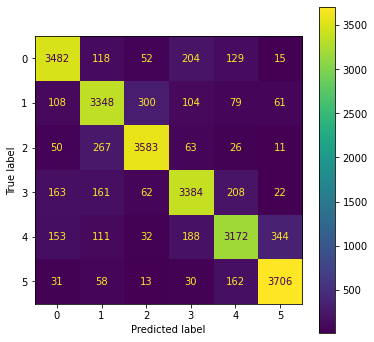

Результаты для варианта обработки 'stop_words':
   Время, затраченное на обучение: 1929.81904
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4000
           1       0.84      0.84      0.84      4000
           2       0.89      0.90      0.89      4000
           3       0.87      0.87      0.87      4000
           4       0.87      0.81      0.84      4000
           5       0.89      0.96      0.92      4000

    accuracy                           0.88     24000
   macro avg       0.88      0.88      0.88     24000
weighted avg       0.88      0.88      0.88     24000



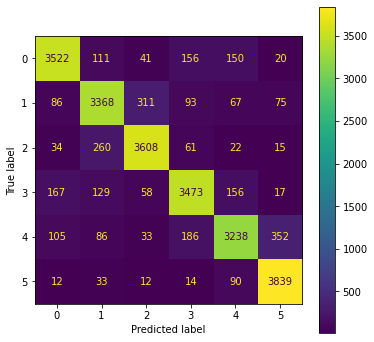

In [16]:
results[model_name] = investigation(ensemble, params, data, model_name, custom_cv) # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

Сравнение полученных F1 score:

In [17]:
max(results[model_name].items(), key=lambda x: x[1]) # поиск максимального значения в словаре ([1] — по значению, а не ключу)

('stop_words', 0.8764558383927791)

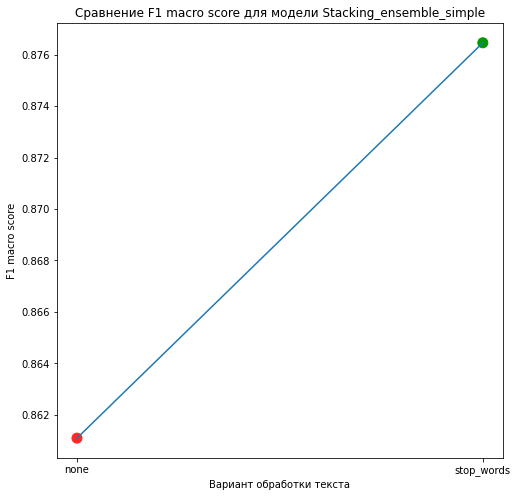

In [18]:
compare_results(results[model_name], model_name) # сравнение получившихся метрик

Параметры лучшей модели:

In [ ]:
ensemble = model_load(f"{MODELS_DIR}{model_name}_stop_words.pkl") # загружаем ансамбль, получивший наивысший f1 score
ensemble.get_params() # параметры моделей в ансамбле

{'cv': None,
 'estimators': [('knn_1',
   KNeighborsClassifier(n_neighbors=3, weights='distance')),
  ('dt_1',
   DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                          max_depth=20, min_samples_split=10, random_state=42)),
  ('mnb_1', MultinomialNB(force_alpha=True))],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': 'balanced',
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 100,
 'final_estimator__multi_class': 'auto',
 'final_estimator__n_jobs': None,
 'final_estimator__penalty': 'l2',
 'final_estimator__random_state': 42,
 'final_estimator__solver': 'lbfgs',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(class_weight='balanced', random_state=42),
 'n_jobs': None,
 'passthrough': False,
 'stack_method': 

## 2) Stacking ensemble, основанный на Boosting моделях

* В качестве Boosting моделей на первом слое будут использоваться сразу несколько классификаторов, а именно — **AdaBoostClassifier** и **GradientBoostingClassifier**.
* Результат работы первого слоя будет передаваться в логистическую регрессию (**Logistic Regression**), которая, в свою очередь, и будет давать финальное предсказание.

In [19]:
params = [{
    # параметры AdaBoostClassifier
    'ada_1__estimator': [DecisionTreeClassifier(max_depth=1)], # базовый классификатор
    'ada_1__n_estimators': [50], # максимальное число классификаторов в Boosting модели (в случае perfect fit — процедура обучения прервётся раньше, то есть не будет дообучать оставшиеся классификаторы)
    'ada_1__learning_rate': [0.01], # вес, применяемый к каждому классификатору на каждой boosting итерации (Weight applied to each classifier at each boosting iteration)
    'ada_1__random_state': [RANDOM_STATE], # число для задания случайности

    # параметры GradientBoostingClassifier
    'grad_1__n_estimators': [20], # число этапов бустинга (GradientBoostingClassifier устойчив к переобучению) (The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.)
    'grad_1__learning_rate': [0.1], # вклад слабых деревьев в модель
    'grad_1__max_features': [None], # # число рассматриваемых фич ('столбцов' в датасете) при делении в узле (для best split)
    'grad_1__max_depth': [2], # максимальная глубина каждого Boosting дерева
    'grad_1__loss': ['log_loss'], # функция потерь, подлежащая оптимизации
    'grad_1__random_state': [RANDOM_STATE], # число для задания случайности

    # параметры Logistic Regression
    "final_estimator__penalty": ["l2"], # тип штрафа за неправильное предсказание
    "final_estimator__C": [1.0], # параметр регуляризации (чем меньше — тем сильнее регуляризация)
    "final_estimator__class_weight": ["balanced"], # балансировка весов для классов
    "final_estimator__solver": ["lbfgs"], # алгоритм, используемый для оптимизации решения
    "final_estimator__max_iter": [500], # максимальное число итерация для solver, чтобы сойтись
    "final_estimator__warm_start": [False], # использовать ли решение с предыдущего вызова fit, как начальное
    "final_estimator__random_state": [RANDOM_STATE] # число для задания случайности
    }]

layer_one_estimators = [ # первый слой Stacking ансамбля, состоящий из следующих моделей:
                        ('ada_1', AdaBoostClassifier()), # AdaBoostClassifier
                        ('grad_1', GradientBoostingClassifier()) # GradientBoostingClassifier
                       ]

final_estimator = LogisticRegression() # финальное предсказание делает логистическая регрессия (в sklearn есть встроенный LabelEncoder, что строковые таргеты конвертирует в числа, поэтому регрессия может работать без ручного приведения таргетов к числовому формату)

model_name = "Stacking_ensemble_Boosting" # название модели

In [20]:
ensemble = StackingClassifier(estimators=layer_one_estimators, final_estimator=final_estimator) # создаём Stacking ансамбль, на первом уровне которого идут модели, указаные в layer_one_estimators, а на финальном — final_estimator
ensemble

StackingClassifier(estimators=[('ada_1', AdaBoostClassifier()),
                               ('grad_1', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression())

Результаты для варианта обработки 'none':
   Время, затраченное на обучение: 13087.49914
              precision    recall  f1-score   support

           0       0.94      0.38      0.54      4000
           1       0.38      0.92      0.53      4000
           2       0.91      0.72      0.80      4000
           3       0.95      0.62      0.75      4000
           4       0.93      0.62      0.75      4000
           5       0.88      0.93      0.90      4000

    accuracy                           0.70     24000
   macro avg       0.83      0.70      0.71     24000
weighted avg       0.83      0.70      0.71     24000



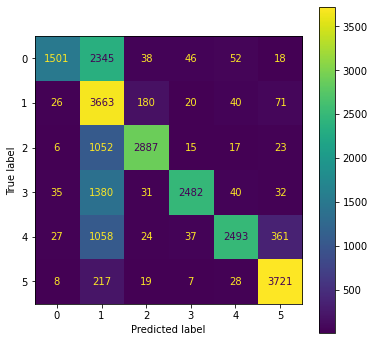

Результаты для варианта обработки 'stop_words':
   Время, затраченное на обучение: 8966.11358
              precision    recall  f1-score   support

           0       0.95      0.36      0.52      4000
           1       0.39      0.91      0.55      4000
           2       0.91      0.72      0.80      4000
           3       0.95      0.69      0.80      4000
           4       0.94      0.65      0.77      4000
           5       0.88      0.93      0.91      4000

    accuracy                           0.71     24000
   macro avg       0.84      0.71      0.72     24000
weighted avg       0.84      0.71      0.72     24000



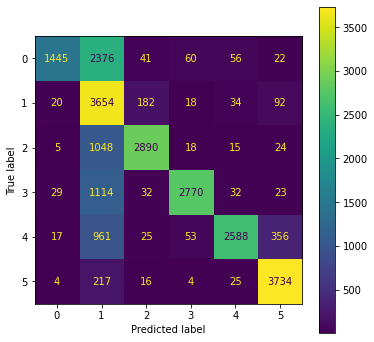

In [21]:
results[model_name] = investigation(ensemble, params, data, model_name, custom_cv) # обучаем модель, перебираем параметры, сохраняем, оцениванием и запоминаем результатa

Сравнение полученных F1 score:

In [22]:
max(results[model_name].items(), key=lambda x: x[1]) # поиск максимального значения в словаре ([1] — по значению, а не ключу)

('stop_words', 0.7244396165456789)

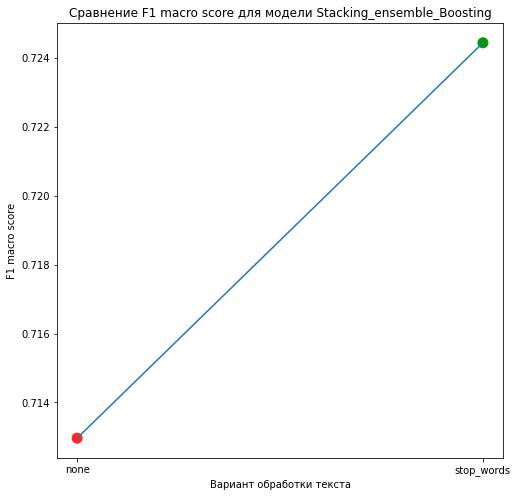

In [23]:
compare_results(results[model_name], model_name) # сравнение получившихся метрик

Параметры лучшей модели:

In [24]:
ensemble = model_load(f"{MODELS_DIR}{model_name}_stop_words.pkl") # загружаем ансамбль, получивший наивысший f1 score
ensemble.get_params() # параметры моделей в ансамбле

{'cv': None,
 'estimators': [('ada_1',
   AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                      learning_rate=0.01, random_state=42)),
  ('grad_1',
   GradientBoostingClassifier(max_depth=2, n_estimators=20, random_state=42))],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': 'balanced',
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 500,
 'final_estimator__multi_class': 'auto',
 'final_estimator__n_jobs': None,
 'final_estimator__penalty': 'l2',
 'final_estimator__random_state': 42,
 'final_estimator__solver': 'lbfgs',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
 'n_jobs': None,
 'passthrough': False,
 'stack_method': 'auto',
 'verbose': 0,
 'ada_1': Ad

# Выводы

In [25]:
pd.DataFrame(results).style.background_gradient(cmap=cmap, axis=1).set_properties(**{'color': 'black'}) # сравнение вариантов по строке (варианту предобработки текста)

,Stacking_ensemble_simple,Stacking_ensemble_Boosting
none,0.861100,0.712963
stop_words,0.876456,0.724440


In [26]:
pd.DataFrame(results).style.background_gradient(cmap=cmap, axis=0).set_properties(**{'color': 'black'}) # сравнение вариантов по столбцу (типу классификатора)

,Stacking_ensemble_simple,Stacking_ensemble_Boosting
none,0.861100,0.712963
stop_words,0.876456,0.724440


**Результаты:**
* Stacking классификатор, основанный на простых моделях, значительно обогнал по F1 macro score тот, что базировался на Boosting моделях. (~0.87 против ~0.72)
* Stacking классификатор, основанный на простых моделях, обучался 32 минуты, а на Boosting моделях 3 часа (в среднем, с учётом кросс-валидации и без перебора параметров).
* При количестве фич в 5000 (не представлено в работе) простой Stacking классификатор доходил до score в 0.91, тогда как на Boosting моделях и за 15 часов не смог обучиться.
* Удаление стоп-слов улучшило качество классификации для обоих ансамблей (примерно на 0.01).